In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np
import sklearn.metrics as sklm
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import networkx as nx
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  lp.cable_id, lp.cable_name, lp.cable_length, lp.cable_finish_year,cccp.capacity, cccp.cost, cccp.pair from landing_points lp left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id where capacity is not null group by lp.cable_id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [3]:
cable_coor

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,acs-alaska-oregon-network-akorn,ACS Alaska-Oregon Network (AKORN),3000.0,2009.0,0.010000,100.000,4.0
1,adria-1,Adria-1,440.0,1996.0,0.000622,13.400,NaN
2,aec-1,AEC-1,5521.0,2016.0,78.000000,300.000,6.0
3,africa-1,Africa-1,10000.0,2023.0,192.000000,250.000,8.0
4,africa-coast-to-europe-ace,Africa Coast to Europe (ACE),17000.0,2012.0,20.000000,700.000,NaN
...,...,...,...,...,...,...,...
234,uk-channel-islands-8,UK-Channel Islands-8,237.0,1994.0,0.000155,16.263,NaN
235,unisur,Unisur,265.0,1995.0,0.000560,74.000,NaN
236,unityeac-pacific,Unity/EAC-Pacific,9620.0,2010.0,76.800000,300.000,8.0
237,west-africa-cable-system-wacs,West Africa Cable System (WACS),14530.0,2012.0,14.500000,600.000,4.0


In [4]:
print(cable_coor['cable_finish_year'].min())
print(cable_coor['cable_finish_year'].max())

1991.0
2026.0


In [5]:
cable_coor['capacityPairRatio'] = cable_coor['capacity']/ cable_coor['pair']
cable_coor['logCapacity'] = np.log2(cable_coor['capacity'])
cable_coor['logCapacityPairRatioy'] = np.log2(cable_coor['capacityPairRatio'])

cable_coor['modifiedYear'] = cable_coor['cable_finish_year'] - 1991

cable_coor['cost_perKM'] = cable_coor['cost']/cable_coor['cable_length'] * 1000

cable_coor

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair,capacityPairRatio,logCapacity,logCapacityPairRatioy,modifiedYear,cost_perKM
0,acs-alaska-oregon-network-akorn,ACS Alaska-Oregon Network (AKORN),3000.0,2009.0,0.010000,100.000,4.0,0.002500,-6.643856,-8.643856,18.0,33.333333
1,adria-1,Adria-1,440.0,1996.0,0.000622,13.400,NaN,NaN,-10.650798,NaN,5.0,30.454545
2,aec-1,AEC-1,5521.0,2016.0,78.000000,300.000,6.0,13.000000,6.285402,3.700440,25.0,54.337982
3,africa-1,Africa-1,10000.0,2023.0,192.000000,250.000,8.0,24.000000,7.584963,4.584963,32.0,25.000000
4,africa-coast-to-europe-ace,Africa Coast to Europe (ACE),17000.0,2012.0,20.000000,700.000,NaN,NaN,4.321928,NaN,21.0,41.176471
...,...,...,...,...,...,...,...,...,...,...,...,...
234,uk-channel-islands-8,UK-Channel Islands-8,237.0,1994.0,0.000155,16.263,NaN,NaN,-12.655444,NaN,3.0,68.620253
235,unisur,Unisur,265.0,1995.0,0.000560,74.000,NaN,NaN,-10.802286,NaN,4.0,279.245283
236,unityeac-pacific,Unity/EAC-Pacific,9620.0,2010.0,76.800000,300.000,8.0,9.600000,6.263034,3.263034,19.0,31.185031
237,west-africa-cable-system-wacs,West Africa Cable System (WACS),14530.0,2012.0,14.500000,600.000,4.0,3.625000,3.857981,1.857981,21.0,41.293875


Text(0.5, 1.0, 'Growth of the cable capacity from 1990 - 2025')

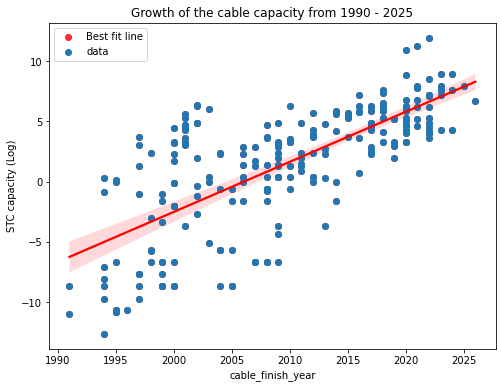

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(x='cable_finish_year',y='logCapacity',data=cable_coor, fit_reg=True, color = 'r',label='Best fit line') 
plt.scatter(cable_coor['cable_finish_year'], cable_coor['logCapacity'], label='data')
plt.ylabel('STC capacity (Log)')  
ax.legend(loc='best')
plt.title("Growth of the cable capacity from 1990 - 2025")
# r2 = sklm.r2_score(cable_coor['modifiedYear'], cable_coor['capacityPairRatio'])
# print(r2)

In [7]:
model_description = sm.OLS(endog=cable_coor['logCapacity'], exog=sm.add_constant(cable_coor['cable_finish_year'])).fit()

# Multi-regression
# temp = cable_coor.loc[:, ['logCapacity', 'modifiedYear', 'pair']].dropna()
# model_description = sm.OLS(endog=temp['logCapacity'], exog=sm.add_constant(temp.loc[:, ['modifiedYear', 'pair']].dropna())).fit()


model_description.summary()

# y = 0.4155 * x + -833.4225


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logCapacity   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     254.8
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           1.93e-39
Time:                        09:43:14   Log-Likelihood:                -644.88
No. Observations:                 239   AIC:                             1294.
Df Residuals:                     237   BIC:                             1301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -833.4225     52.298    -15.936      0.000    -936.450    -730.395
cable_finish_year     0.4155      0.026     15.963      0.000       0.364       0.467
==============================================================================
Omnibus:                        0.338   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.844   Jarque-Bera (JB):                0.483
Skew:                          -0.029   Prob(JB):                        0.785
Kurtosis:                       2.788   Cond. No.                     4.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
temp = cable_coor.loc[:, ['logCapacity','logCapacityPairRatioy', 'cable_finish_year', 'pair','cost_perKM']].dropna()
model_description = sm.OLS(endog=temp['logCapacityPairRatioy'], exog=sm.add_constant(temp.loc[:, ['cable_finish_year', 'pair','cost_perKM']].dropna())).fit()


model_description.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     logCapacityPairRatioy   R-squared:                       0.548
Model:                               OLS   Adj. R-squared:                  0.539
Method:                    Least Squares   F-statistic:                     63.07
Date:                   Sun, 13 Mar 2022   Prob (F-statistic):           9.26e-27
Time:                           09:43:14   Log-Likelihood:                -414.07
No. Observations:                    160   AIC:                             836.1
Df Residuals:                        156   BIC:                             848.4
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -659.6816     58.962    -11.188      0.000    -776.149    -543.215
cable_finish_year     0.3286      0.029     11.209      0.000       0.271       0.386
pair                 -0.0666      0.011     -5.918      0.000      -0.089      -0.044
cost_perKM           -0.0018      0.002     -1.150      0.252      -0.005       0.001
==============================================================================
Omnibus:                       15.248   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.414
Skew:                          -0.669   Prob(JB):                     0.000165
Kurtosis:                       3.905   Cond. No.                     4.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(temp['cable_finish_year'], temp['logCapacity'], 'o', label='data')
# ax.plot(temp['cable_finish_year'], model_description.fittedvalues, 'r--.',label='OLS')
# ax.legend(loc='best')

In [10]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    raw_noCapacity = pd.read_sql("select  lp.cable_id, lp.cable_name, lp.cable_length, lp.cable_finish_year,cccp.capacity, cccp.cost, cccp.pair from landing_points lp left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id where capacity is  null group by lp.cable_id",con=con)

raw_noCapacity

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,2africa,2Africa,45000.0,2023.0,None,925.000,16.0
1,aden-djibouti,Aden-Djibouti,269.0,1994.0,None,6.725,NaN
2,alaska-united-turnagain-arm-auta,Alaska United Turnagain Arm (AUTA),53.0,2012.0,None,1.325,NaN
3,amerigo-vespucci,Amerigo Vespucci,85.0,1999.0,None,15.000,NaN
4,antillas-1,Antillas 1,650.0,1997.0,None,NaN,NaN
...,...,...,...,...,...,...,...
264,ulysses-2,Ulysses 2,NaN,1997.0,None,NaN,NaN
265,venezuelan-festoon,Venezuelan Festoon,1200.0,1998.0,None,NaN,NaN
266,wall-li,WALL-LI,60.0,2024.0,None,3.125,96.0
267,x-link-submarine-cable,X-Link Submarine Cable,775.0,2019.0,None,19.375,NaN


In [11]:
raw_noCapacity['capacity'] = 2 ** (0.4155 * raw_noCapacity['cable_finish_year'] + -833.4225)
raw_noCapacity

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,2africa,2Africa,45000.0,2023.0,140.458488,925.000,16.0
1,aden-djibouti,Aden-Djibouti,269.0,1994.0,0.033135,6.725,NaN
2,alaska-united-turnagain-arm-auta,Alaska United Turnagain Arm (AUTA),53.0,2012.0,5.911401,1.325,NaN
3,amerigo-vespucci,Amerigo Vespucci,85.0,1999.0,0.139855,15.000,NaN
4,antillas-1,Antillas 1,650.0,1997.0,0.078618,NaN,NaN
...,...,...,...,...,...,...,...
264,ulysses-2,Ulysses 2,NaN,1997.0,0.078618,NaN,NaN
265,venezuelan-festoon,Venezuelan Festoon,1200.0,1998.0,0.104857,NaN,NaN
266,wall-li,WALL-LI,60.0,2024.0,187.338031,3.125,96.0
267,x-link-submarine-cable,X-Link Submarine Cable,775.0,2019.0,44.384991,19.375,NaN


In [12]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    raw_withCost = pd.read_sql("select  lp.cable_id, lp.cable_name, lp.cable_length, lp.cable_finish_year,cccp.capacity, cccp.cost, cccp.pair from landing_points lp left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id where cccp.cost is not null and cable_length is not null group by lp.cable_id",con=con)

raw_withCost

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,2africa,2Africa,45000.0,2023.0,NaN,925.000,16.0
1,acs-alaska-oregon-network-akorn,ACS Alaska-Oregon Network (AKORN),3000.0,2009.0,0.010000,100.000,4.0
2,aden-djibouti,Aden-Djibouti,269.0,1994.0,NaN,6.725,NaN
3,adria-1,Adria-1,440.0,1996.0,0.000622,13.400,NaN
4,aec-1,AEC-1,5521.0,2016.0,78.000000,300.000,6.0
...,...,...,...,...,...,...,...
336,unisur,Unisur,265.0,1995.0,0.000560,74.000,NaN
337,unityeac-pacific,Unity/EAC-Pacific,9620.0,2010.0,76.800000,300.000,8.0
338,wall-li,WALL-LI,60.0,2024.0,NaN,3.125,96.0
339,west-africa-cable-system-wacs,West Africa Cable System (WACS),14530.0,2012.0,14.500000,600.000,4.0


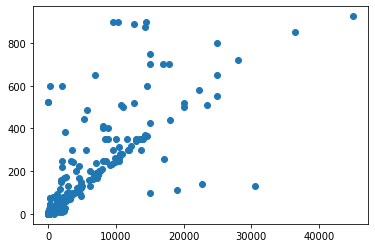

In [13]:
plt.scatter(raw_withCost['cable_length'], raw_withCost['cost'], label='data')


In [14]:
model_description = sm.OLS(endog=raw_withCost['cost'], exog=sm.add_constant(raw_withCost['cable_length'])).fit()
model_description.summary()

# y = 0.0250 * x + 32.7843

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cost   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     558.3
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           1.23e-73
Time:                        09:43:14   Log-Likelihood:                -2123.8
No. Observations:                 341   AIC:                             4252.
Df Residuals:                     339   BIC:                             4259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           32.7843      7.822      4.191      0.000      17.398      48.170
cable_length     0.0250      0.001     23.627      0.000       0.023       0.027
==============================================================================
Omnibus:                      184.442   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2302.654
Skew:                           1.951   Prob(JB):                         0.00
Kurtosis:                      15.118   Cond. No.                     8.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    raw_noCost = pd.read_sql("select  lp.cable_id, lp.cable_name, lp.cable_length, lp.cable_finish_year,cccp.capacity, cccp.cost, cccp.pair from landing_points lp left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id where cccp.cost is null and cable_length is not null group by lp.cable_id",con=con)

raw_noCost

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,antillas-1,Antillas 1,650.0,1997.0,NaN,None,NaN
1,apollo-east-and-west,Apollo East and West,670.0,2024.0,NaN,None,NaN
2,arsat-submarine-fiber-optic-cable,ARSAT Submarine Fiber Optic Cable,40.0,2012.0,NaN,None,NaN
3,asia-connect-cable-1-acc1,Asia Connect Cable 1 (ACC1),18000.0,2024.0,NaN,None,NaN
4,atlas-offshore,Atlas Offshore,1634.0,2007.0,NaN,None,NaN
...,...,...,...,...,...,...,...
130,trans-caspian-fiber-optic-tcfo,Trans Caspian Fiber Optic (TCFO),341.0,2022.0,NaN,None,NaN
131,transcan-2,TRANSCAN-2,238.0,1990.0,NaN,None,NaN
132,turcyos-1,Turcyos-1,110.0,1993.0,NaN,None,NaN
133,venezuelan-festoon,Venezuelan Festoon,1200.0,1998.0,NaN,None,NaN


In [16]:
raw_noCost['cost'] = round( (0.0250 * raw_noCost['cable_length'] + 32.7843) ,2)
raw_noCost


,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,antillas-1,Antillas 1,650.0,1997.0,NaN,49.03,NaN
1,apollo-east-and-west,Apollo East and West,670.0,2024.0,NaN,49.53,NaN
2,arsat-submarine-fiber-optic-cable,ARSAT Submarine Fiber Optic Cable,40.0,2012.0,NaN,33.78,NaN
3,asia-connect-cable-1-acc1,Asia Connect Cable 1 (ACC1),18000.0,2024.0,NaN,482.78,NaN
4,atlas-offshore,Atlas Offshore,1634.0,2007.0,NaN,73.63,NaN
...,...,...,...,...,...,...,...
130,trans-caspian-fiber-optic-tcfo,Trans Caspian Fiber Optic (TCFO),341.0,2022.0,NaN,41.31,NaN
131,transcan-2,TRANSCAN-2,238.0,1990.0,NaN,38.73,NaN
132,turcyos-1,Turcyos-1,110.0,1993.0,NaN,35.53,NaN
133,venezuelan-festoon,Venezuelan Festoon,1200.0,1998.0,NaN,62.78,NaN


In [17]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  lp.cable_id, lp.cable_name, lp.cable_length, lp.cable_finish_year,cccp.capacity, cccp.cost, cccp.pair from landing_points lp left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id group by lp.cable_id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)
cable_coor

,cable_id,cable_name,cable_length,cable_finish_year,capacity,cost,pair
0,2africa,2Africa,45000.0,2023.0,NaN,925.000,16.0
1,acs-alaska-oregon-network-akorn,ACS Alaska-Oregon Network (AKORN),3000.0,2009.0,0.010000,100.000,4.0
2,aden-djibouti,Aden-Djibouti,269.0,1994.0,NaN,6.725,NaN
3,adria-1,Adria-1,440.0,1996.0,0.000622,13.400,NaN
4,aec-1,AEC-1,5521.0,2016.0,78.000000,300.000,6.0
...,...,...,...,...,...,...,...
499,wall-li,WALL-LI,60.0,2024.0,NaN,3.125,96.0
500,west-africa-cable-system-wacs,West Africa Cable System (WACS),14530.0,2012.0,14.500000,600.000,4.0
501,x-link-submarine-cable,X-Link Submarine Cable,775.0,2019.0,NaN,19.375,NaN
502,yellow,Yellow,7001.0,2000.0,NaN,NaN,NaN


In [18]:
raw_noCapacity.to_csv("/Users/dijiongyuequ/Downloads/raw_noCapacity.csv")
raw_noCost.to_csv("/Users/dijiongyuequ/Downloads/raw_noCost.csv")

## Data refactor

In [34]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_predict = pd.read_sql("select lp.cable_id, lp.cable_name, lp.cable_length, cable_owners, cable_suppliers, cable_finish, lp.cable_finish_year, cccp.capacity as ac_cap, cccp.cost as ac_cost, cccp.pair as ac_pair, nCap.capacity as pre_cap, nCost.cost as pre_cost from landing_points lp left join raw_noCapacity nCap on lp.cable_id = nCap.cable_id left join cable_cost_capacity_pair cccp on lp.cable_id = cccp.cable_id left join raw_noCost nCost on lp.cable_id = nCost.cable_id group by lp.cable_id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)
cable_predict


,cable_id,cable_name,cable_length,cable_owners,cable_suppliers,cable_finish,cable_finish_year,ac_cap,ac_cost,ac_pair,pre_cap,pre_cost
0,2africa,2Africa,45000.0,"China Mobile, MTN Group, Meta, Orange, Saudi T...",ASN,2023,2023.0,NaN,925.000,16.0,140.458488,NaN
1,acs-alaska-oregon-network-akorn,ACS Alaska-Oregon Network (AKORN),3000.0,Alaska Communications,Subcom,2009 April,2009.0,0.010000,100.000,4.0,NaN,NaN
2,aden-djibouti,Aden-Djibouti,269.0,"Djibouti Telecom, Orange, Tata Communications,...",ASN,1994,1994.0,NaN,6.725,NaN,0.033135,NaN
3,adria-1,Adria-1,440.0,"ALBtelecom, Hrvatski Telekom",ASN,1996 September,1996.0,0.000622,13.400,NaN,NaN,NaN
4,aec-1,AEC-1,5521.0,Aqua Comms,Subcom,2016 January,2016.0,78.000000,300.000,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
499,wall-li,WALL-LI,60.0,Crosslake Fibre,None,2024 Q4,2024.0,NaN,3.125,96.0,187.338031,NaN
500,west-africa-cable-system-wacs,West Africa Cable System (WACS),14530.0,"Altice Portugal, Angola Cables, Broadband Infr...",ASN,2012 May,2012.0,14.500000,600.000,4.0,NaN,NaN
501,x-link-submarine-cable,X-Link Submarine Cable,775.0,E-Networks Inc.,None,2019 December,2019.0,NaN,19.375,NaN,44.384991,NaN
502,yellow,Yellow,7001.0,Lumen,Subcom,2000 September,2000.0,NaN,NaN,NaN,0.186533,207.81


In [35]:
# missing = cable_coor['ac_cap'].isnull() # get nans
# target = cable_coor['pre_cap']
# new_open = cable_coor['ac_cap'].copy() # make copy

# # loop missing and test against a True value
# # if so, get the 'Last' value at index and
# # populate new_open value at index
# for i in range(missing.shape[0]):
#     if missing[i] == True:
#         new_open.iloc[i] = target.iloc[i]

# # replace the 'Open' values with new 'Open' values
# cable_coor['Open'] = new_open
# cable_coor

def merge_actual_predict_value(df, act_columnName, pre_columnName, mer_columnName):
    missing = df[act_columnName].isnull() # get nans
    target = df[pre_columnName]
    new_open = df[act_columnName].copy() # make copy

    # loop missing and test against a True value
    # if so, get the Last value at index and
    # populate new_open value at index
    for i in range(missing.shape[0]):
        if missing[i] == True:
            new_open.iloc[i] = target.iloc[i]

    # replace the Open values with new Open values
    df[mer_columnName] = new_open

# merge capacity
merge_actual_predict_value(cable_predict, "ac_cap", "pre_cap", "merge_capacity") 
merge_actual_predict_value(cable_predict, "ac_cost", "pre_cost", "merge_cost") 

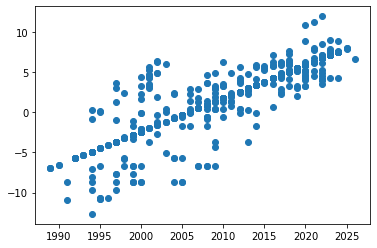

In [36]:
# cable_coor
cable_predict['logCapacity'] = np.log2(cable_predict['merge_capacity'])
plt.scatter(cable_predict['cable_finish_year'], cable_predict['logCapacity'], label='data')


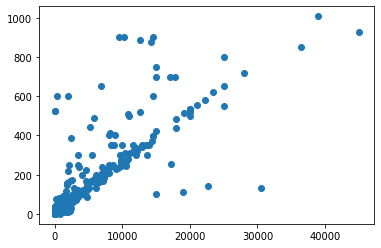

In [37]:
plt.scatter(cable_predict['cable_length'], cable_predict['merge_cost'], label='data')


In [38]:
cable_predict.to_csv("/Users/dijiongyuequ/Downloads/cable_predict.csv")
